# CTA 2D source fitting with Sherpa


## Prepare sky images
We first create counts, exposure, background and PSF maps, following the steps under "Make sky images" in the cta_data_analysis Notebook:

In [1]:
%matplotlib inline
from astropy.coordinates import SkyCoord
import astropy.units as u
from gammapy.image import SkyImage, IACTBasicImageEstimator
from gammapy.background import RingBackgroundEstimator
from gammapy.data import DataStore
from regions import CircleSkyRegion

# Create reference image: 6x6 deg FOV centered on (l,b) = (284,0)
target_position = SkyCoord(284, 0, unit='deg', frame='galactic')

xref = target_position.galactic.l.value
yref = target_position.galactic.b.value

ref_image = SkyImage.empty(
    nxpix=300, nypix=300, binsz=0.02,
    xref=xref, yref=yref,
    proj='TAN', coordsys='GAL')

We initially define no exclusion regions for the background estimation, as we have not yet determined the positions of sources in the field of view:

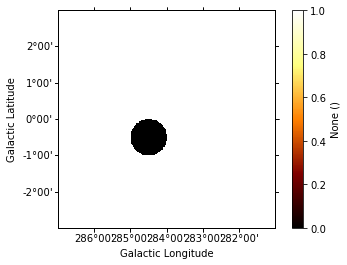

In [2]:
#But we trick here by masking the bright sources
on_region = CircleSkyRegion(center=SkyCoord(284.5, -0.5, unit='deg', frame='galactic'), radius=0.5 * u.deg)

excl_mask = ref_image.region_mask(on_region)
excl_mask.data = np.invert(excl_mask.data)

excl_mask.plot(add_cbar=True)

bkg_estimator = RingBackgroundEstimator(
    r_in=0.6 * u.deg,
    width=0.2 * u.deg)

Set the map energy threshold at 300 GeV, which seems a good compromise for source detection sensitivity: with a low threshold the background is more important, but too high a threshold yields limited source statistics.

In [3]:
image_estimator = IACTBasicImageEstimator(
    reference=ref_image,
    emin=0.3 * u.TeV,
    emax=100 * u.TeV,
    offset_max=4 * u.deg,
    background_estimator=bkg_estimator,
    exclusion_mask=excl_mask)

OBS_ID
------
110030
110111
110031
110028
110110
110029
110071
110068
110112
110070
110113
110069 observations within radius


/Users/facero/Documents/Work/Program/gammapy/gammapy/gammapy/cube/core.py:85: RuntimeWarning: divide by zero encountered in log
  log_data = np.log(self.data.value)
/Users/facero/Documents/Work/Program/Anaconda/envs/cta/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2444: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


counts


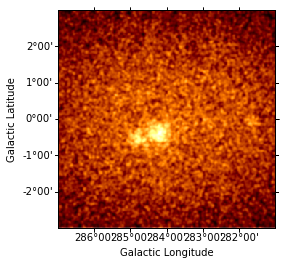

exposure


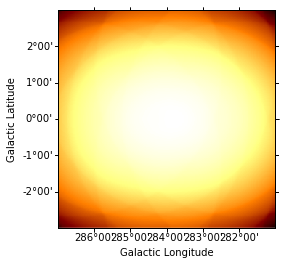

background


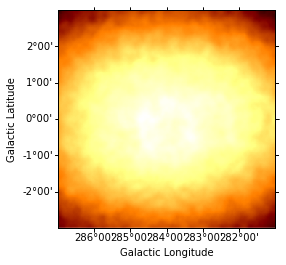

excess


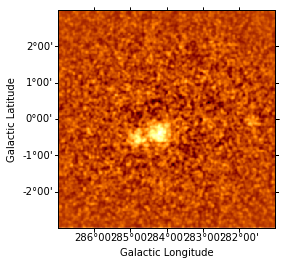

flux


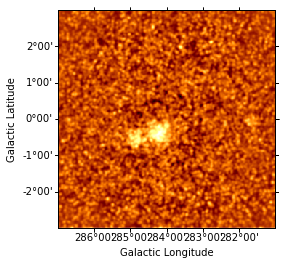

psf


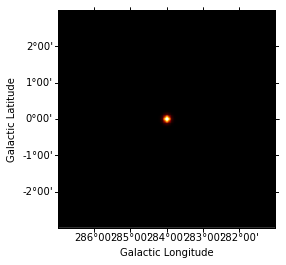

In [4]:
#Change here the path to your index file
INDX_DIR = '/Users/facero/Documents/Work/CTA/meetings/gammapy-meudon-tutorial/handson/index/gps'

data_store = DataStore.from_dir(INDX_DIR)

ras = data_store.obs_table['RA_PNT'] * u.deg
decs = data_store.obs_table['DEC_PNT'] * u.deg
pointings = SkyCoord(ras, decs, frame='icrs' )
dists = pointings.separation(target_position)
obs_id = data_store.obs_table['OBS_ID'][(dists < 3 * u.deg)]
print((obs_id), "observations within radius")


obslist = data_store.obs_list(obs_id)
images = image_estimator.run(obslist)

for i,im in enumerate(images):
    print(images.names[i])
    im.smooth(radius=3).plot(stretch='sqrt') ; plt.show()

Now save the obtained images as FITS files for import into Sherpa:

In [18]:
#create dir if not existing
#Commands starting with a ! are shell commands
#!mkdir data

images['counts']    .write("data/G284-0_test_counts.fits", clobber=True)
images['exposure']  .write("data/G284-0_test_exposure.fits", clobber=True)
images['background'].write("data/G284-0_test_background.fits", clobber=True)

# Hack to convert PSF data from an array of Quantity's to a float array:
images['psf'].data = images['psf'].data.value
images['psf']       .write("data/G284-0_test_psf.fits", clobber=True)


## Fit sources with Sherpa
Set up Sherpa to fit the counts map, loading the ancillary images for subsequent use. A relevant test statistic for data with Poisson fluctuations is the one proposed by Cash (1979). The simplex (or Nelder-Mead) fitting algorithm is a good compromise between efficiency and robustness. The source fit is best performed in pixel coordinates.

In [5]:
import sherpa.astro.ui as sh
from gammapy.image import SkyImage
from regions.core.pixcoord import PixCoord
from regions.shapes.circle import CirclePixelRegion

sh.set_stat("cash")
sh.set_method("simplex")
sh.load_image("data/G284-0_test_counts.fits")
sh.set_coord("logical")

sh.load_table_model("expo", "data/G284-0_test_exposure.fits")
sh.load_table_model("bkg",  "data/G284-0_test_background.fits")
sh.load_psf        ("psf",  "data/G284-0_test_psf.fits")

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find xpaget on your PATH'


In principle one might first want to fit the background amplitude. However the background estimation method already yields the correct normalization, so we freeze the background amplitude to unity instead of adjusting it. The (smoothed) residuals from this background model are then computed and shown.

(<matplotlib.figure.Figure at 0x1209fdc50>,
 <matplotlib.colorbar.Colorbar at 0x121b86e48>)

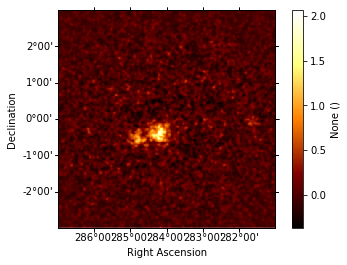

In [6]:
sh.set_full_model(bkg)
bkg.ampl = 1
sh.freeze(bkg)

sh.save_resid("data/resid.fits", clobber=True)
resid = SkyImage.read("data/resid.fits")
resid_smo3 = resid.smooth(radius = 3)
resid_smo3.plot(add_cbar=True)

We then find the position of the maximum in the (smoothed) residuals map, and fit a (symmetrical) Gaussian source with that initial position:

In [21]:
maxcoord = resid_smo3.lookup_max()
maxpix = resid_smo3.wcs_skycoord_to_pixel(maxcoord[0])
sh.set_full_model(bkg + psf(sh.gauss2d.g0) * expo) # creates g0 as a gauss2d instance
g0.xpos = maxpix[0]
g0.ypos = maxpix[1]
sh.freeze(g0.xpos, g0.ypos) # fix the position in the initial fitting step

expo.ampl = 1e-9 # fix exposure amplitude so that typical exposure is of order unity
sh.freeze(expo)
sh.thaw(g0.fwhm, g0.ampl) # in case frozen in a previous iteration

g0.fwhm = 10 # give some reasonable initial values
g0.ampl = maxcoord[1]
sh.fit() # Performs the fit; this takes a little time.

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 116674
Final fit statistic   = 115257 at function evaluation 233
Data points           = 90000
Degrees of freedom    = 89998
Change in statistic   = 1417.34
   g0.fwhm        24.0267     
   g0.ampl        0.186056    


Fit all parameters of this Gaussian component, fix them and re-compute the residuals map.

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 115257
Final fit statistic   = 115232 at function evaluation 331
Data points           = 90000
Degrees of freedom    = 89996
Change in statistic   = 24.4249
   g0.fwhm        27.2242     
   g0.xpos        136.198     
   g0.ypos        129.202     
   g0.ampl        0.164647    


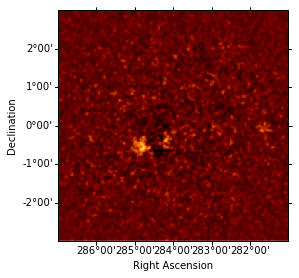

In [22]:
sh.thaw(g0.xpos, g0.ypos)
sh.fit()
sh.freeze(g0)

sh.save_resid("data/resid.fits", clobber=True)
resid = SkyImage.read("data/resid.fits")
resid_smo3 = resid.smooth(radius = 3)
resid_smo3.show(vmin = -0.5, vmax = 2)

Instantiate additional Gaussian components, and use them to iteratively fit sources:

In [ ]:
for i in range(1,3) :
    sh.create_model_component('gauss2d', 'g'+str(i))
gs = [g0, g1, g2]
sh.set_full_model(bkg + psf(g0+g1+g2) * expo)

for i in range(1, len(gs)) :
    gs[i].ampl = 0   # initialize components with fixed, zero amplitude
    sh.freeze(gs[i])

for i in range(1, len(gs)) :
    maxcoord = resid_smo3.lookup_max()
    maxpix = resid_smo3.wcs_skycoord_to_pixel(maxcoord[0])
    gs[i].xpos = maxpix[0]
    gs[i].ypos = maxpix[1]
    gs[i].fwhm = 10
    gs[i].fwhm = maxcoord[1]

    sh.thaw(gs[i].fwhm)
    sh.thaw(gs[i].ampl)
    sh.fit()

    sh.thaw(gs[i].xpos)
    sh.thaw(gs[i].ypos)
    sh.fit()
    sh.freeze(gs[i])

    sh.save_resid("data/resid.fits", clobber=True)
    resid = SkyImage.read("data/resid.fits")
    resid_smo3 = resid.smooth(radius = 3)
    resid_smo3.show(vmin = -0.5, vmax = 2)